In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [2]:
#load data
flights = pd.read_csv('flights.csv')
flights['DELAYED'] = flights['ARRIVAL_DELAY'] > 0

C:\Users\rkies\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


For this assignment, I am using data on delayed flights. I created a new variable called "Delayed" that is True if a flight arrives on time and false if it does not. Next, I checked for missing values.

In [3]:
#check for missing values
flights.isnull().sum()*100/flights.isnull().count()

YEAR                    0.000000
MONTH                   0.000000
DAY                     0.000000
DAY_OF_WEEK             0.000000
AIRLINE                 0.000000
FLIGHT_NUMBER           0.000000
TAIL_NUMBER             0.252978
ORIGIN_AIRPORT          0.000000
DESTINATION_AIRPORT     0.000000
SCHEDULED_DEPARTURE     0.000000
DEPARTURE_TIME          1.480526
DEPARTURE_DELAY         1.480526
TAXI_OUT                1.530259
WHEELS_OFF              1.530259
SCHEDULED_TIME          0.000103
ELAPSED_TIME            1.805629
AIR_TIME                1.805629
DISTANCE                0.000000
WHEELS_ON               1.589822
TAXI_IN                 1.589822
SCHEDULED_ARRIVAL       0.000000
ARRIVAL_TIME            1.589822
ARRIVAL_DELAY           1.805629
DIVERTED                0.000000
CANCELLED               0.000000
CANCELLATION_REASON    98.455357
AIR_SYSTEM_DELAY       81.724960
SECURITY_DELAY         81.724960
AIRLINE_DELAY          81.724960
LATE_AIRCRAFT_DELAY    81.724960
WEATHER_DE

Certain variables (cancellation reason, air system delay, security delay, airline delay, late aircraft delay, and weather delay) are missing values for more than 80% of the data so I am going to drop those variables. For the other variables, less than 2% of the values are missing, so I will go ahead and drop the rows with missing values for the other variables.

In [4]:
#drop variables with missing data and missing values
flights = flights.drop(['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 
                       'WEATHER_DELAY'], 1 )
flights = flights.dropna()

Next, I will look at the variable types and distributions of the numeric variables.

In [5]:
#check data types
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5714008 entries, 0 to 5819078
Data columns (total 26 columns):
YEAR                   int64
MONTH                  int64
DAY                    int64
DAY_OF_WEEK            int64
AIRLINE                object
FLIGHT_NUMBER          int64
TAIL_NUMBER            object
ORIGIN_AIRPORT         object
DESTINATION_AIRPORT    object
SCHEDULED_DEPARTURE    int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE               int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL      int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED               int64
CANCELLED              int64
DELAYED                bool
dtypes: bool(1), float64(11), int64(10), object(4)
memory usage: 1.1+ GB


In [6]:
#get data distributions
flights.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
count,5714008.0,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,...,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5714008.0,5714008.0
mean,2015.0,6.547799e+00,1.570759e+01,3.932643e+00,2.164384e+03,1.328907e+03,1.335066e+03,9.294842e+00,1.606550e+01,1.357099e+03,...,1.370062e+02,1.135116e+02,8.244569e+02,1.471319e+03,7.429063e+00,1.493187e+03,1.476373e+03,4.407057e+00,0.0,0.0
std,0.0,3.397421e+00,8.774394e+00,1.985967e+00,1.754706e+03,4.835251e+02,4.964198e+02,3.688972e+01,8.882449e+00,4.980237e+02,...,7.421107e+01,7.223082e+01,6.086620e+02,5.218682e+02,5.618951e+00,5.069011e+02,5.259730e+02,3.927130e+01,0.0,0.0
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,...,1.400000e+01,7.000000e+00,3.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.700000e+01,0.0,0.0
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,7.280000e+02,9.160000e+02,9.210000e+02,-5.000000e+00,1.100000e+01,9.350000e+02,...,8.200000e+01,6.000000e+01,3.730000e+02,1.054000e+03,4.000000e+00,1.110000e+03,1.058000e+03,-1.300000e+01,0.0,0.0
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.681000e+03,1.325000e+03,1.330000e+03,-2.000000e+00,1.400000e+01,1.343000e+03,...,1.180000e+02,9.400000e+01,6.500000e+02,1.508000e+03,6.000000e+00,1.520000e+03,1.512000e+03,-5.000000e+00,0.0,0.0
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.211000e+03,1.730000e+03,1.740000e+03,7.000000e+00,1.900000e+01,1.754000e+03,...,1.680000e+02,1.440000e+02,1.065000e+03,1.911000e+03,9.000000e+00,1.917000e+03,1.916000e+03,8.000000e+00,0.0,0.0
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.320000e+03,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,...,7.660000e+02,6.900000e+02,4.983000e+03,2.400000e+03,2.480000e+02,2.400000e+03,2.400000e+03,1.971000e+03,0.0,0.0


Airline, tail number, origin airport and destination airport are all string object type variables, so I will not be incorporating those variables into the model. Year, diverted, and cancelled all take only a single value, so including those in the model will not add any additional information.

Next, I will look at the percentage of flights that were delayed to use to compare the model performance to just defining all flights as a single group.

In [7]:
#check percentage of delayed and not delayed flights
print('Not Delayed Flights: ', len(flights[flights['DELAYED'] == False]))
print('Delayed Flights: ', len(flights[flights['DELAYED'] == True]))
len(flights[flights['DELAYED'] == False])/len(flights)

Not Delayed Flights:  3627112
Delayed Flights:  2086896


0.6347754500868742

From this, we can see that 63% of flights are not delayed.

Next, we will define our decision tree and measure runtime. In addition to the variables mentioned above, we will also drop Arrival Delay, as that is the variable that was used to define the delayed variable, and thus could be used to separate the two groups with a single branch.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.449054 to fit

--- 14.680357217788696 seconds ---


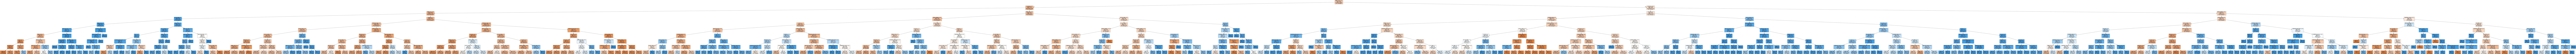

In [12]:
#decision tree
#get decision tree runtime
import time
start_time = time.time()

# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=9,
)

X = flights.drop(['DELAYED', 'YEAR', 'AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY',
                 'CANCELLED', 'DIVERTED'], 1)
Y = flights['DELAYED']
decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names= [ 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 
                    'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
                    'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
                   ],
    class_names=['Not Delayed', 'Delayed'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('original_tree.png')

print("--- %s seconds ---" % (time.time() - start_time))
Image('original_tree.png')

In [13]:
#get accuracy of decision tree
y_pred = decision_tree.predict(X)
print('Accuracy:', accuracy_score(Y, y_pred))

Accuracy: 0.7062672995907601


The decision tree is difficult to read, but runs quickly.

Next, we will define the simplest random forest model that we can and determine runtime.

In [10]:
#get correlation between variables
flights[[ 'DELAYED', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 
         'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 
         'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']].corr()

,DELAYED,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME
DELAYED,1.000000,-0.053362,-0.007515,-0.012046,0.012122,0.125385,0.159684,0.431709,0.277161,0.162410,-0.010044,0.068616,0.025251,-0.001931,0.105531,0.143489,0.111189,0.097476
MONTH,-0.053362,1.000000,0.005315,-0.009427,-0.019988,-0.000214,-0.004032,-0.021827,-0.013069,-0.004913,0.010337,0.001871,0.003379,0.010612,-0.008950,0.001937,-0.010361,-0.009164
DAY,-0.007515,0.005315,1.000000,0.002099,0.002916,-0.001793,-0.002691,-0.000257,-0.002594,-0.003322,0.002888,0.001419,0.001923,0.002977,-0.004320,-0.001868,-0.003878,-0.004335
DAY_OF_WEEK,-0.012046,-0.009427,0.002099,1.000000,0.015153,0.007737,0.005588,-0.011450,-0.020648,0.004048,0.014611,0.011510,0.014284,0.015931,0.005617,0.001034,0.006874,0.005621
FLIGHT_NUMBER,0.012122,-0.019988,0.002916,0.015153,1.000000,-0.006971,-0.001527,-0.008889,0.050418,0.005302,-0.316079,-0.306611,-0.319681,-0.329824,-0.006199,-0.019736,-0.015119,-0.002896
SCHEDULED_DEPARTURE,0.125385,-0.000214,-0.001793,0.007737,-0.006971,1.000000,0.963988,0.110419,0.006551,0.938134,-0.015846,-0.017935,-0.015756,-0.008854,0.657801,-0.044686,0.705042,0.631086
DEPARTURE_TIME,0.159684,-0.004032,-0.002691,0.005588,-0.001527,0.963988,1.000000,0.171840,0.013926,0.971992,-0.020817,-0.021990,-0.021146,-0.016426,0.677625,-0.040621,0.710183,0.650051
DEPARTURE_DELAY,0.431709,-0.021827,-0.000257,-0.011450,-0.008889,0.110419,0.171840,1.000000,0.058423,0.162664,0.027582,0.030805,0.023495,0.023957,0.059091,0.012479,0.097689,0.049652
TAXI_OUT,0.277161,-0.013069,-0.002594,-0.020648,0.050418,0.006551,0.013926,0.058423,1.000000,0.039007,0.112274,0.205195,0.087608,0.072284,0.032684,0.003065,0.024307,0.029863
WHEELS_OFF,0.162410,-0.004913,-0.003322,0.004048,0.005302,0.938134,0.971992,0.162664,0.039007,1.000000,-0.028287,-0.027133,-0.029654,-0.027562,0.697496,-0.038824,0.721840,0.669799


In [11]:
#random forest
#get runtime
import time
start_time = time.time()

#define random forest model
rfc = ensemble.RandomForestClassifier()
X = flights.drop(['DELAYED', 'YEAR', 'AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY',
                  'DIVERTED', 'CANCELLED', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER',
                   'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME', 
                  'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
                               ], 1)
Y = flights['DELAYED']
print(cross_val_score(rfc, X, Y, cv=10))

#print runtime
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

[0.82706046 0.82837302 0.81834299 0.81926353 0.83507204 0.83314345
 0.84538677 0.81763388 0.81788939 0.82782289]
--- 1290.4005327224731 seconds ---


To create the simplest random forest model possible, I incorporated as few features as were needed to create a model that performed better than one that just classified all flights as not delayed would. The simplest random forest model has a very significantly longer runtime than the decision tree. Incorporating more features into the random forest model could improve performance but would also significantly increase runtime.